# News Classifier

### Импорт библиотек

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import datetime
import time
import os
import sys
import json
import csv
import nltk
import re
import tqdm
import pickle
import random

from datetime import datetime, timedelta
from pathlib import Path
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    AdaBoostClassifier, VotingClassifier
)
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import LinearSVC
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset

### Загрузка датасета и EDA

In [92]:
data_dir = Path("data")
file_name = "all_news_2025-12-23.csv"
file_path = data_dir / file_name
df = pd.read_csv(file_path, parse_dates=['Publication Date'])

df_filtered = df.copy()
politics_indices = df_filtered[df_filtered['Topic'] == 'Politics'].index
keep_percentage = 0.2
n_politics_to_keep = int(len(politics_indices) * keep_percentage)
random.seed(42)
politics_to_keep = random.sample(list(politics_indices), n_politics_to_keep)
mask_keep = df_filtered.index.isin(politics_to_keep) | (df_filtered['Topic'] != 'Politics')
df = df_filtered[mask_keep].copy()

display(df)

,Website,Title,Author,Publication Date,Link,Picture Link,Category,Topic,Relevance
0,RT,Corruption-hit aide still calling shots in Kie...,RT,2025-12-21 09:52:05,https://www.rt.com/russia/629835-corruption-sc...,https://mf.b37mrtl.ru/files/2025.12/thumbnail/...,NaN,Unknown,2
1,RT,Google sued for using AI to snoop on users,RT,2025-11-13 15:33:13,https://www.rt.com/business/627746-google-priv...,https://mf.b37mrtl.ru/files/2025.11/thumbnail/...,Бизнес,Science and tech,1
3,Vedomosti.ru,«Рецепт счастья»: едим дома,Роман Черкасов,2025-08-22 00:01:32,https://www.vedomosti.ru/media/columns/2025/08...,https://cdn.vdmsti.ru/image/2025/6h/1djd7l/nor...,Медиа,Health,1
4,Vedomosti.ru,Банки занялись мошенниками,Ярослав Сталь,2025-10-20 00:06:33,https://www.vedomosti.ru/opinion/columns/2025/...,https://cdn.vdmsti.ru/image/2025/85/7uvh/norma...,Мнения,Economics,1
5,RT,US tech giants advising foreign workers not to...,RT,2025-12-22 03:37:02,https://www.rt.com/news/629858-us-tech-foreign...,https://mf.b37mrtl.ru/files/2025.12/thumbnail/...,Новости,Science and tech,2
...,...,...,...,...,...,...,...,...,...
3201,Vedomosti.ru,Как новые,Олег Волошин,2025-09-08 00:01:47,https://www.vedomosti.ru/opinion/columns/2025/...,https://cdn.vdmsti.ru/image/2025/6y/192axk/nor...,Мнения / Аналитика,Unknown,1
3204,Vedomosti.ru,Внедрению ИИ в строительную отрасль препятству...,Юлия Малева,2024-05-03 01:01:11,https://www.vedomosti.ru/management/articles/2...,https://cdn.vdmsti.ru/image/2024/3g/25ndb/norm...,Менеджмент / Рынок труда,Economics,1
3205,Vedomosti.ru,Мамута объяснил разницу между блокировкой и пр...,Ведомости,2025-11-18 14:47:58,https://www.vedomosti.ru/finance/news/2025/11/...,https://cdn.vdmsti.ru/image/2025/8y/vowx8/norm...,Финансы / Банки,Weather,1
3207,Vedomosti.ru,«Это была рука Бога»: карьера футбольного гени...,"""Анастасия Винницкая, Юлия Томинова-Ерашова""",2025-10-30 07:33:58,https://www.vedomosti.ru/lifestyle/galleries/2...,https://cdn.vdmsti.ru/image/2025/8d/zv7c6/norm...,Стиль жизни / Спорт,Sport,1


#### Анализ датасета

In [93]:
print("1. Общая информация:")
print("-"*40)
print(df.info())
    
print("\n2. Статистика признаков:")
print("-"*40)
display(df.describe(include='all').T)
    
print("\n3. Пропуски в данных:")
print("-"*40)
missing_data = pd.DataFrame({
    'Количество': df.isnull().sum(),
    'Доля в процентах': (df.isnull().sum() / len(df)) * 100
}).sort_values('Количество', ascending=False)
  
display(missing_data[missing_data['Количество'] > 0])
    
print("\n4. Уникальные значения по признакам:")
print("-"*40)
unique_counts = {}
for col in df.columns:
    unique_counts[col] = df[col].nunique()
unique_df = pd.DataFrame({
    'Колонка': list(unique_counts.keys()),
    'Количество уникальных значений': list(unique_counts.values())
})
display(unique_df)

print("\n5. Статистика по категориям:")
print("-"*40)

print("\n5.1 Распределение по веб-сайтам:")
website_stats = df['Website'].value_counts()
print(f"Всего сайтов: {website_stats.shape[0]}")
display(website_stats)

print("\n5.2 Распределение по темам (Topic):")
topic_stats = df['Topic'].value_counts()
display(topic_stats)

print("\n5.3 Распределение релевантности (Relevance):")
relevance_stats = df['Relevance'].value_counts().sort_index()
display(relevance_stats)

print("\n5.4 Статистика релевантности:")
print(f"Средняя релевантность: {df['Relevance'].mean():.2f}")
print(f"Медианная релевантность: {df['Relevance'].median():.2f}")
print(f"Минимальная релевантность: {df['Relevance'].min()}")
print(f"Максимальная релевантность: {df['Relevance'].max()}")

print("\n5.5 Распределение по категориям (Category):")
category_stats = df['Category'].value_counts().head(15)
display(category_stats)

print("\n6. Временные характеристики:")
print("-"*40)

df['Date'] = df['Publication Date'].dt.date
df['Hour'] = df['Publication Date'].dt.hour
df['DayOfWeek'] = df['Publication Date'].dt.day_name()
df['Month'] = df['Publication Date'].dt.month_name()

print("\n6.1 Количество новостей по дням:")
daily_stats = df['Date'].value_counts().sort_index()
print(f"Период охвата: {daily_stats.index.min()} - {daily_stats.index.max()}")
print(f"Всего дней: {daily_stats.shape[0]}")
print(f"Среднее количество новостей в день: {daily_stats.mean():.1f}")

print("\n7. Статистика заголовков:")
print("-"*40)

df['Title_Length'] = df['Title'].apply(lambda x: len(str(x)))
df['Title_Word_Count'] = df['Title'].apply(lambda x: len(str(x).split()))

print(f"Средняя длина заголовка: {df['Title_Length'].mean():.1f} символов")
print(f"Максимальная длина: {df['Title_Length'].max()} символов")
print(f"Минимальная длина: {df['Title_Length'].min()} символов")
print(f"Среднее количество слов: {df['Title_Word_Count'].mean():.1f}")

1. Общая информация:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 1876 entries, 0 to 3209
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Website           1876 non-null   object        
 1   Title             1876 non-null   object        
 2   Author            1799 non-null   object        
 3   Publication Date  1876 non-null   datetime64[ns]
 4   Link              1876 non-null   object        
 5   Picture Link      1677 non-null   object        
 6   Category          1675 non-null   object        
 7   Topic             1876 non-null   object        
 8   Relevance         1876 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 146.6+ KB
None

2. Статистика признаков:
----------------------------------------


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Website,1876,6,Vedomosti.ru,1199,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Title,1876,1763,Для IT-компаний определили обязательства финан...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Author,1799,308,Ведомости,468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Publication Date,1876,NaN,NaN,NaN,2025-10-23 18:27:50.351812352,2023-10-22 23:50:36,2025-10-09 15:36:47.500000,2025-12-05 10:11:44,2025-12-20 15:23:35.750000128,2025-12-23 23:11:51,NaN
Link,1876,1764,https://lenta.ru/articles/2025/12/10/evreyskie...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Picture Link,1677,1566,https://cdn.vdmsti.ru/image/2025/9l/1bb57z/nor...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,1675,74,Мнения,292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Topic,1876,11,Economics,430,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relevance,1876.0,NaN,NaN,NaN,1.527719,1.0,1.0,1.0,1.0,5.0,1.065723



3. Пропуски в данных:
----------------------------------------


,Количество,Доля в процентах
Category,201,10.714286
Picture Link,199,10.607676
Author,77,4.104478



4. Уникальные значения по признакам:
----------------------------------------


,Колонка,Количество уникальных значений
0,Website,6
1,Title,1763
2,Author,308
3,Publication Date,1758
4,Link,1764
5,Picture Link,1566
6,Category,74
7,Topic,11
8,Relevance,5



5. Статистика по категориям:
----------------------------------------

5.1 Распределение по веб-сайтам:
Всего сайтов: 6


Website
Vedomosti.ru    1199
RT               344
Lenta.ru         175
RG               100
TASS              56
Gazeta.ru          2
Name: count, dtype: int64


5.2 Распределение по темам (Topic):


Topic
Economics              430
Unknown                386
Politics               333
Science and tech       250
Culture                130
Society                126
Health                  76
Sport                   45
Travels and tourism     39
Weather                 31
Accidents               30
Name: count, dtype: int64


5.3 Распределение релевантности (Relevance):


Relevance
1    1416
2     176
3      93
4     136
5      55
Name: count, dtype: int64


5.4 Статистика релевантности:
Средняя релевантность: 1.53
Медианная релевантность: 1.00
Минимальная релевантность: 1
Максимальная релевантность: 5

5.5 Распределение по категориям (Category):


Category
Мнения                                      292
Россия                                      109
Финансы / Банки                              85
Поп-культура                                 65
Недвижимость / Коммерческая недвижимость     60
Новости                                      60
Бизнес                                       54
Недвижимость / Жилая недвижимость            47
Экономика / Макроэкономика и бюджет          47
Стиль жизни / Культура                       43
Технологии / Интернет и digital              42
Менеджмент / Рынок труда                     39
Авто / Автомобильная промышленность          38
Авто / Легковые автомобили                   37
Финансы                                      33
Name: count, dtype: int64


6. Временные характеристики:
----------------------------------------

6.1 Количество новостей по дням:
Период охвата: 2023-10-22 - 2025-12-23
Всего дней: 270
Среднее количество новостей в день: 6.9

7. Статистика заголовков:
----------------------------------------
Средняя длина заголовка: 59.3 символов
Максимальная длина: 131 символов
Минимальная длина: 9 символов
Среднее количество слов: 8.7


#### Построение графиков

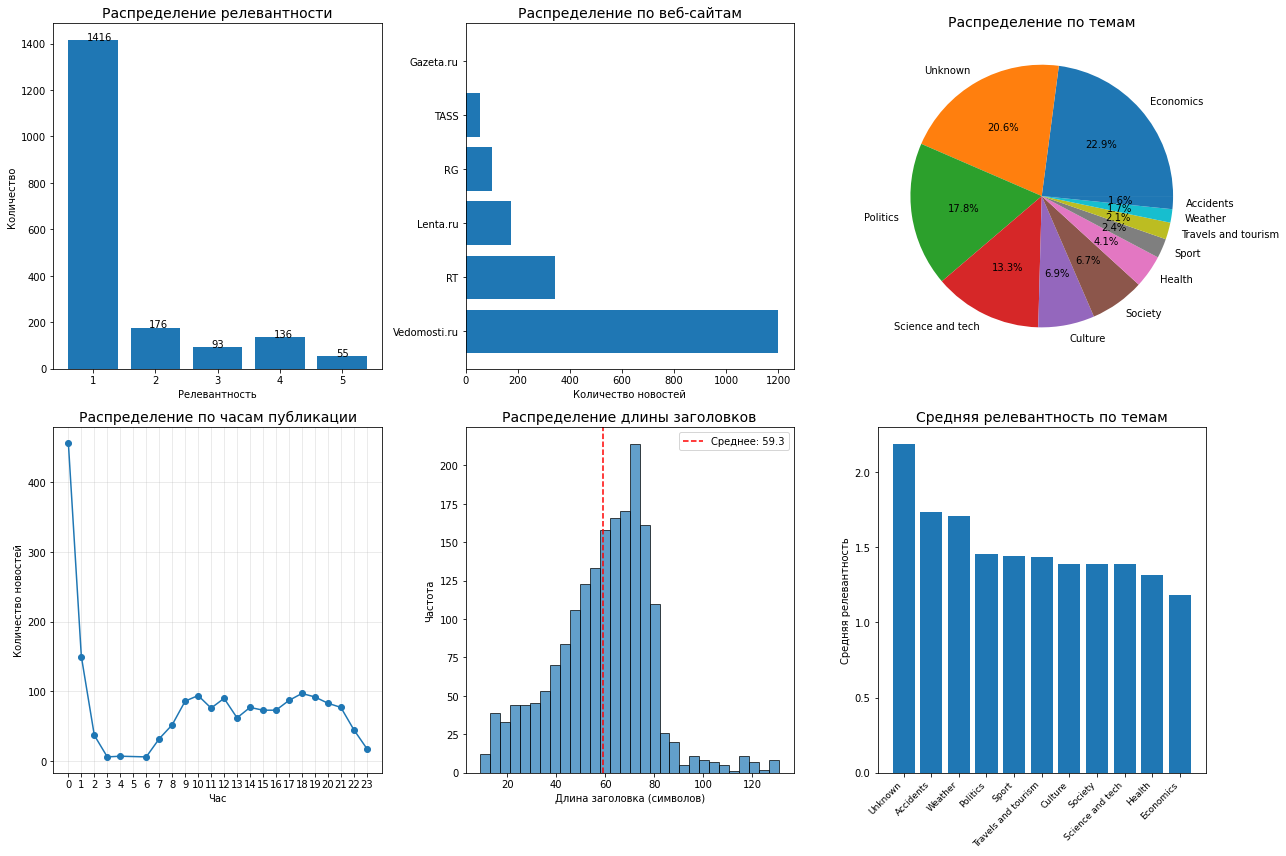

In [94]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].bar(df['Relevance'].value_counts().sort_index().index, 
               df['Relevance'].value_counts().sort_index().values)
axes[0, 0].set_title('Распределение релевантности', fontsize=14)
axes[0, 0].set_xlabel('Релевантность')
axes[0, 0].set_ylabel('Количество')
for i, v in enumerate(df['Relevance'].value_counts().sort_index().values):
    axes[0, 0].text(i+0.9, v + 0.5, str(v), fontsize=10)

top_websites = df['Website'].value_counts()
axes[0, 1].barh(range(len(top_websites)), top_websites.values)
axes[0, 1].set_yticks(range(len(top_websites)))
axes[0, 1].set_yticklabels(top_websites.index)
axes[0, 1].set_title('Распределение по веб-сайтам', fontsize=14)
axes[0, 1].set_xlabel('Количество новостей')

topics_counts = df['Topic'].value_counts()
axes[0, 2].pie(topics_counts.values, labels=topics_counts.index, autopct='%1.1f%%')
axes[0, 2].set_title('Распределение по темам', fontsize=14)

hour_counts = df['Hour'].value_counts().sort_index()
axes[1, 0].plot(hour_counts.index, hour_counts.values, marker='o')
axes[1, 0].set_title('Распределение по часам публикации', fontsize=14)
axes[1, 0].set_xlabel('Час')
axes[1, 0].set_ylabel('Количество новостей')
axes[1, 0].set_xticks(range(0, 24))
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(df['Title_Length'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Распределение длины заголовков', fontsize=14)
axes[1, 1].set_xlabel('Длина заголовка (символов)')
axes[1, 1].set_ylabel('Частота')
axes[1, 1].axvline(df['Title_Length'].mean(), color='red', linestyle='--', 
                  label=f'Среднее: {df["Title_Length"].mean():.1f}')
axes[1, 1].legend()

if 'Topic' in df.columns and 'Relevance' in df.columns:
    topic_relevance = df.groupby('Topic')['Relevance'].mean().sort_values(ascending=False)
    axes[1, 2].bar(range(len(topic_relevance)), topic_relevance.values)
    axes[1, 2].set_xticks(range(len(topic_relevance)))
    axes[1, 2].set_xticklabels(topic_relevance.index, rotation=45, ha='right')
    axes[1, 2].set_title('Средняя релевантность по темам', fontsize=14)
    axes[1, 2].set_ylabel('Средняя релевантность')
    axes[1, 2].tick_params(axis='x', labelsize=9)

plt.tight_layout()
plt.show()

Из интересного здесь можно заметить, что большинство новостей опубликовано больше чем 3 дня назад (судя по метрике релевантности), наибольшее количество новостей «опубликовано» в 0 часов 0 минут (хотя это по большей части из-за того, что при публикации был указан только день).

### Подготовка данных для обучения

#### Препроцессинг текста в заголовках

In [95]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zа-яё\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    processed_tokens = []
    for word in tokens:
        if word in all_stopwords or len(word) < 3:
            continue
        lemmatized = lemmatize_word(word)
        if lemmatized:
            processed_tokens.append(lemmatized)
    return ' '.join(processed_tokens)

def lemmatize_word(word, lang='auto'):
    if not word:
        return word
    if lang == 'auto':
        if re.search('[а-яё]', word):
            lang = 'ru'
        else:
            lang = 'en'
    if lang == 'ru':
        return stemmer_ru.stem(word)
    else:
        return lemmatizer_en.lemmatize(word)

df_all = df.copy()
df_train = df_all.copy()
#df_train = df_all[df_all['Topic'] != 'Unknown'].copy()
#df_unknown = df_all[df_all['Topic'] == 'Unknown'].copy()

X_text = df_train['Title'].fillna('').astype(str).values
y = df_train['Topic'].values

try:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    russian_stopwords = set(stopwords.words('russian'))
    english_stopwords = set(stopwords.words('english'))
    all_stopwords = russian_stopwords.union(english_stopwords)
except:
    all_stopwords = set(['the', 'and', 'a', 'an', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'])
lemmatizer_en = WordNetLemmatizer()
stemmer_ru = SnowballStemmer("russian")
    
X_processed = []
for text in X_text:
    X_processed.append(preprocess_text(text))

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Векторизация текста в заголовках и кодирование таргета (столбец Topic)

In [96]:
vectorizer = TfidfVectorizer(
    max_features=5000,  # Ограничиваем количество фич
    min_df=2,           # Слова должны встречаться минимум в 2 заголовках
    max_df=0.8,         # Исключаем слова, встречающиеся в более чем 80% заголовков
    ngram_range=(1, 2)  # Используем униграммы и биграммы (одно или два последовательных слова)
)
label_encoder = LabelEncoder()

X_vectorized = vectorizer.fit_transform(X_processed)
y_encoded = label_encoder.fit_transform(y)

#### Разделение датасета по k-fold (k = 4)

In [97]:
n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_indices = []
fold_splits = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_vectorized, y_encoded), 1):
    fold_indices.append((train_idx, val_idx))
    fold_splits.append({
        'fold': fold,
        'train_size': len(train_idx),
        'val_size': len(val_idx),
        'train_classes': np.bincount(y_encoded[train_idx]),
        'val_classes': np.bincount(y_encoded[val_idx])
    })

#### Проверка распределения по фолдам

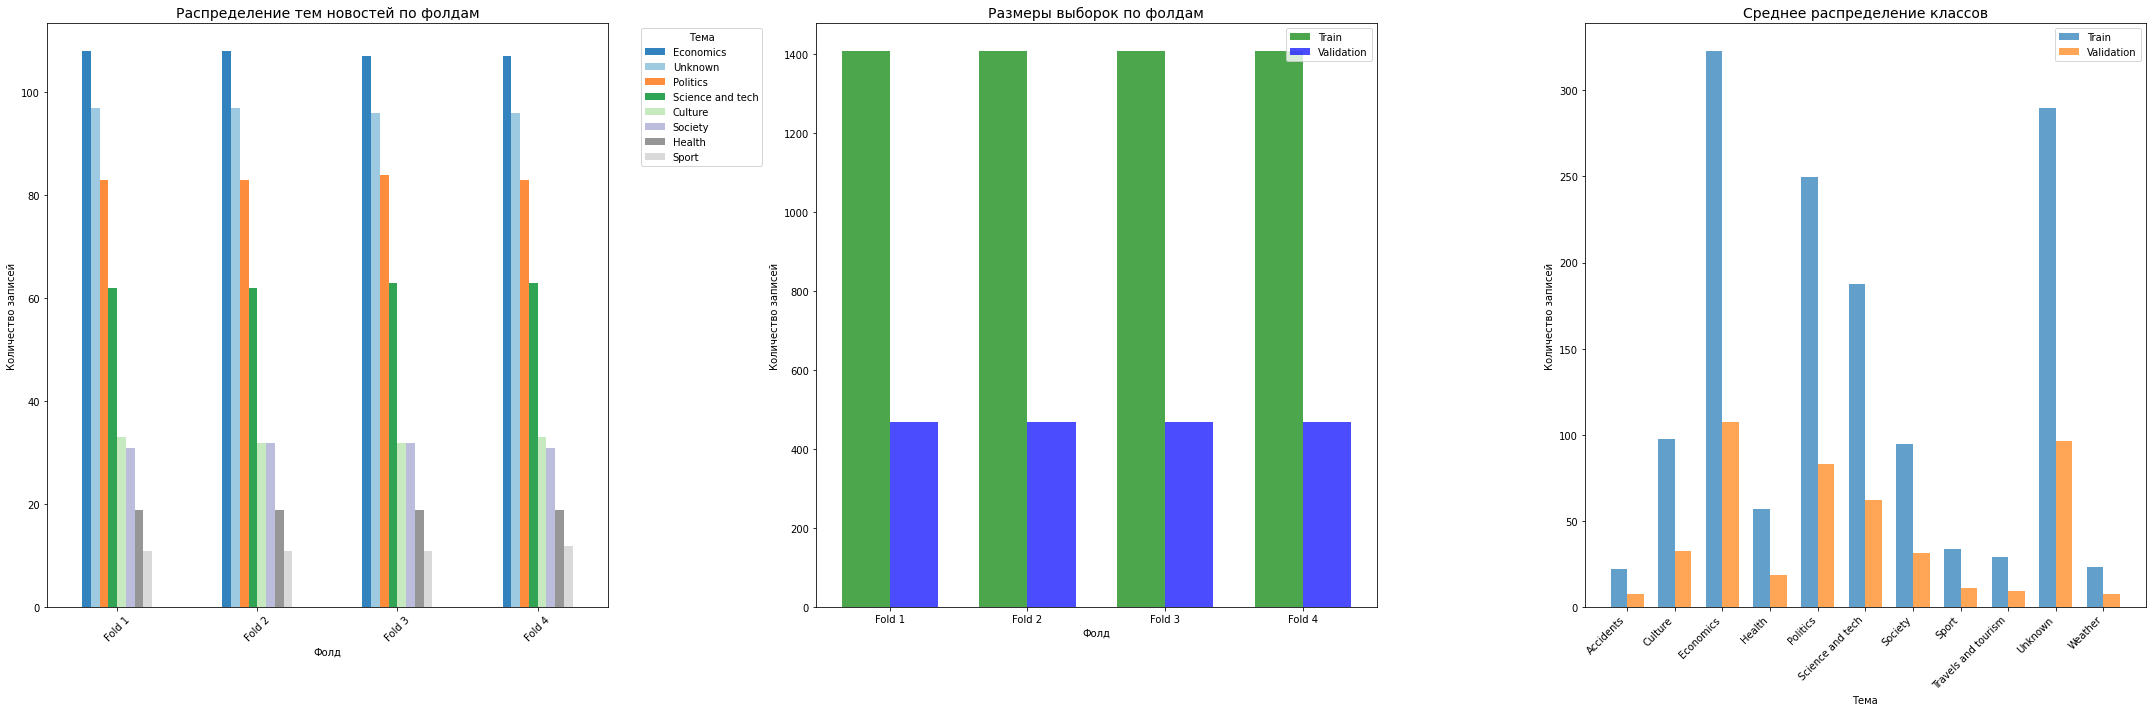

In [98]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

fold_data = []
for fold_info in fold_splits:
    val_classes = fold_info['val_classes']
    fold_data.append(val_classes)

fold_df = pd.DataFrame(fold_data, index=[f'Fold {i+1}' for i in range(n_splits)])
fold_df.columns = label_encoder.classes_



top_topics = fold_df.sum().nlargest(8).index
fold_df[top_topics].plot(kind='bar', ax=axes[0], colormap='tab20c')
axes[0].set_title('Распределение тем новостей по фолдам', fontsize=14)
axes[0].set_xlabel('Фолд')
axes[0].set_ylabel('Количество записей')
axes[0].legend(title='Тема', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)



train_sizes = [fold_info['train_size'] for fold_info in fold_splits]
val_sizes = [fold_info['val_size'] for fold_info in fold_splits]

x = np.arange(n_splits)
width = 0.35

axes[1].bar(x - width/2, train_sizes, width, label='Train', alpha=0.7, color='green')
axes[1].bar(x + width/2, val_sizes, width, label='Validation', alpha=0.7, color='blue')
axes[1].set_title('Размеры выборок по фолдам', fontsize=14)
axes[1].set_xlabel('Фолд')
axes[1].set_ylabel('Количество записей')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'Fold {i+1}' for i in range(n_splits)])
axes[1].legend()



train_class_means = np.mean([fold_info['train_classes'] for fold_info in fold_splits], axis=0)
val_class_means = np.mean([fold_info['val_classes'] for fold_info in fold_splits], axis=0)

x_pos = np.arange(len(label_encoder.classes_))
width = 0.35

axes[2].bar(x_pos - width/2, train_class_means, width, label='Train', alpha=0.7)
axes[2].bar(x_pos + width/2, val_class_means, width, label='Validation', alpha=0.7)
axes[2].set_title('Среднее распределение классов', fontsize=14)
axes[2].set_xlabel('Тема')
axes[2].set_ylabel('Количество записей')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(label_encoder.classes_, rotation=45, ha='right')
axes[2].legend()

plt.tight_layout()
plt.show()

### Поиск моделей для обучения

#### Проверка моделей классического машинного обучения

In [101]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=100000, random_state=42, n_jobs=-1), # Логистическая регрессия
    'SVC': SVC(kernel='rbf', random_state=42, max_iter=100000), # Метод опорных векторов с RBF-ядром
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=0), # Случайный лес
    'MultinomialNB': MultinomialNB(), # Мультиномиальный наивный Байес
}
cv_results_acc = {}
cv_results_f1 = {}

for model_name, model in models.items():
    print(f"\nТестирование модели: {model_name}")
    try:
        cv_scores_acc = cross_val_score(model, X_vectorized, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
        cv_results_acc[model_name] = {
            'mean_accuracy': cv_scores_acc.mean(),
            'std_accuracy': cv_scores_acc.std(),
            'scores': cv_scores_acc
        }
        cv_scores_f1 = cross_val_score(model, X_vectorized, y_encoded, cv=skf, scoring='f1_weighted', n_jobs=-1)
        cv_results_f1[model_name] = {
            'mean_f1': cv_scores_f1.mean(),
            'std_f1': cv_scores_f1.std(),
            'scores': cv_scores_f1
        }
        print(f"Средняя точность: {cv_scores_acc.mean():.3f} (+/- {cv_scores_acc.std():.3f})")
        print(f"Точность по фолдам: {cv_scores_acc}")
        print(f"Средний f1-score: {cv_scores_f1.mean():.3f} (+/- {cv_scores_f1.std():.3f})")
        print(f"F1-score по фолдам: {cv_scores_f1}")
        
    except Exception as e:
        print(f"Ошибка при обучении модели: {e}")
        cv_results_acc[model_name] = None
        cv_results_f1[model_name] = None


Тестирование модели: LogisticRegression
Средняя точность: 0.478 (+/- 0.008)
Точность по фолдам: [0.47547974 0.47334755 0.47121535 0.49253731]
Средний f1-score: 0.415 (+/- 0.012)
F1-score по фолдам: [0.41502099 0.40755555 0.40266872 0.43366108]

Тестирование модели: SVC
Средняя точность: 0.477 (+/- 0.007)
Точность по фолдам: [0.47334755 0.46695096 0.48187633 0.48614072]
Средний f1-score: 0.426 (+/- 0.013)
F1-score по фолдам: [0.42064921 0.41069615 0.42972464 0.4447795 ]

Тестирование модели: RandomForest
Средняя точность: 0.489 (+/- 0.005)
Точность по фолдам: [0.49253731 0.48400853 0.48400853 0.49466951]
Средний f1-score: 0.476 (+/- 0.005)
F1-score по фолдам: [0.48156049 0.4694588  0.4723717  0.48183291]

Тестирование модели: MultinomialNB
Средняя точность: 0.445 (+/- 0.016)
Точность по фолдам: [0.43283582 0.42857143 0.44776119 0.46908316]
Средний f1-score: 0.375 (+/- 0.019)
F1-score по фолдам: [0.36249914 0.36019042 0.37096018 0.40627434]


Судя по выведенным метрикам, наилучшей моделью классического машинного обучения для нашего датасета является случайный лес (при заданных параметрах)

In [102]:
test_examples = [
    "Новые санкции США против России вступили в силу сегодня",
    "Футбольный матч закончился со счетом 2:1 в пользу домашней команды",
    "Внедрение цифровых технологий в транспортную систему сократит пробки на 30%",
    "Курс доллара достиг исторического максимума на бирже",
    "Пожар в жилом доме унес жизни трех человек"
]

models['RandomForest'].fit(X_vectorized, y_encoded)

print("Примеры предсказаний:")
for title in test_examples:
    processed = preprocess_text(title)
    vectorized = vectorizer.transform([processed])
    prediction_encoded = models['RandomForest'].predict(vectorized)[0]
    prediction_label = label_encoder.inverse_transform([prediction_encoded])[0] 
    print(f"'{title}' -> {prediction_label}")

Примеры предсказаний:
'Новые санкции США против России вступили в силу сегодня' -> Politics
'Футбольный матч закончился со счетом 2:1 в пользу домашней команды' -> Unknown
'Внедрение цифровых технологий в транспортную систему сократит пробки на 30%' -> Economics
'Курс доллара достиг исторического максимума на бирже' -> Economics
'Пожар в жилом доме унес жизни трех человек' -> Unknown


### Проверка нейронных сетей

#### Подготовка к обучению

In [103]:
train_x, val_x, train_y, val_y = train_test_split(
    X_processed, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [104]:
class Tokenizer:
    def __init__(self, num_words=10000):
        self.num_words = num_words
        self.word_index = {}
        self.index_word = {}
        
    def fit_on_texts(self, texts):
        word_counts = {}
        
        for text in texts:
            for word in text.split():
                if word in word_counts:
                    word_counts[word] += 1
                else:
                    word_counts[word] = 1
        
        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        self.word_index = {'<PAD>': 0, '<UNK>': 1}
        self.index_word = {0: '<PAD>', 1: '<UNK>'}
        for idx, (word, count) in enumerate(sorted_words[:self.num_words-2]):
            self.word_index[word] = idx + 2
            self.index_word[idx + 2] = word
        
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = []
            for word in text.split():
                sequence.append(self.word_index.get(word, 1))
            sequences.append(sequence)
        return sequences

In [105]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        sequence = self.tokenizer.texts_to_sequences([text])[0]
        
        if len(sequence) < self.max_len:
            sequence = sequence + [0] * (self.max_len - len(sequence))
        else:
            sequence = sequence[:self.max_len]
            
        return torch.tensor(sequence, dtype=torch.long), torch.tensor(label, dtype=torch.long)

In [106]:
class RnnClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding_bn = nn.BatchNorm1d(embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            n_layers, 
            batch_first=True, 
            dropout=dropout if n_layers > 1 else 0,
            bidirectional=True 
        )
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden_combined = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        output = self.linear(hidden_combined)
        
        return output

In [121]:
VOCAB_SIZE = 1000
NUM_EPOCHS = 30
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
N_LAYERS = 2
LR = 0.0005
DROPOUT = 0.2
MAX_LEN = 150
BATCH_SIZE = 64

torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

train_y_encoded = label_encoder.fit_transform(train_y)
val_y_encoded = label_encoder.transform(val_y)
OUTPUT_DIM = len(label_encoder.classes_)

tokenizer = Tokenizer(num_words=VOCAB_SIZE-1)
tokenizer.fit_on_texts(train_x)

train_dataset = TextDataset(train_x, train_y_encoded, tokenizer, MAX_LEN)
val_dataset = TextDataset(val_x, val_y_encoded, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


Используется устройство: cuda
GPU: NVIDIA GeForce GTX 1660 Ti


In [122]:
model = RnnClassifier(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    dropout=DROPOUT
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Всего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

train_losses = []
train_acc = []
val_losses = []
val_acc = []
log_period = 20

Всего параметров: 2,632,972
Обучаемых параметров: 2,632,972


In [123]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*50}")
    print(f"Эпоха {epoch + 1}/{NUM_EPOCHS}")
    print(f"{'='*50}")
    
    print("Обучение:")
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    batch_losses = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)
        
        if batch_idx % log_period == (log_period - 1):
            avg_loss = total_loss / log_period
            accuracy = 100 * correct / total
            batch_losses.append(avg_loss)
            print(f"Loss = {avg_loss:.4f}, Acc = {accuracy:.2f}%")
            total_loss = 0
            correct = 0
            total = 0
    
    epoch_train_loss = np.mean(batch_losses) if batch_losses else 0
    train_losses.append(epoch_train_loss)
    
    print("\nВалидация:")
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            val_loss += loss.item()
            pred = output.argmax(dim=1)
            val_correct += (pred == target).sum().item()
            val_total += target.size(0)
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_acc.append(val_accuracy)
    scheduler.step(avg_val_loss)
    
    print(f"  Validation Loss = {avg_val_loss:.4f}, Validation Accuracy = {val_accuracy:.2f}%")
    print(f"  Learning Rate = {optimizer.param_groups[0]['lr']:.6f}")


Эпоха 1/30
Обучение:
Loss = 2.1693, Acc = 23.67%

Валидация:
  Validation Loss = 2.0309, Validation Accuracy = 28.46%
  Learning Rate = 0.000500

Эпоха 2/30
Обучение:
Loss = 2.0086, Acc = 25.00%

Валидация:
  Validation Loss = 1.9763, Validation Accuracy = 31.38%
  Learning Rate = 0.000500

Эпоха 3/30
Обучение:
Loss = 1.9265, Acc = 33.05%

Валидация:
  Validation Loss = 1.9227, Validation Accuracy = 34.57%
  Learning Rate = 0.000500

Эпоха 4/30
Обучение:
Loss = 1.8028, Acc = 38.75%

Валидация:
  Validation Loss = 1.8460, Validation Accuracy = 36.44%
  Learning Rate = 0.000500

Эпоха 5/30
Обучение:
Loss = 1.7013, Acc = 43.75%

Валидация:
  Validation Loss = 1.7806, Validation Accuracy = 39.89%
  Learning Rate = 0.000500

Эпоха 6/30
Обучение:
Loss = 1.5764, Acc = 47.34%

Валидация:
  Validation Loss = 1.8023, Validation Accuracy = 39.36%
  Learning Rate = 0.000500

Эпоха 7/30
Обучение:
Loss = 1.5155, Acc = 50.08%

Валидация:
  Validation Loss = 1.7658, Validation Accuracy = 41.76%
  Lea

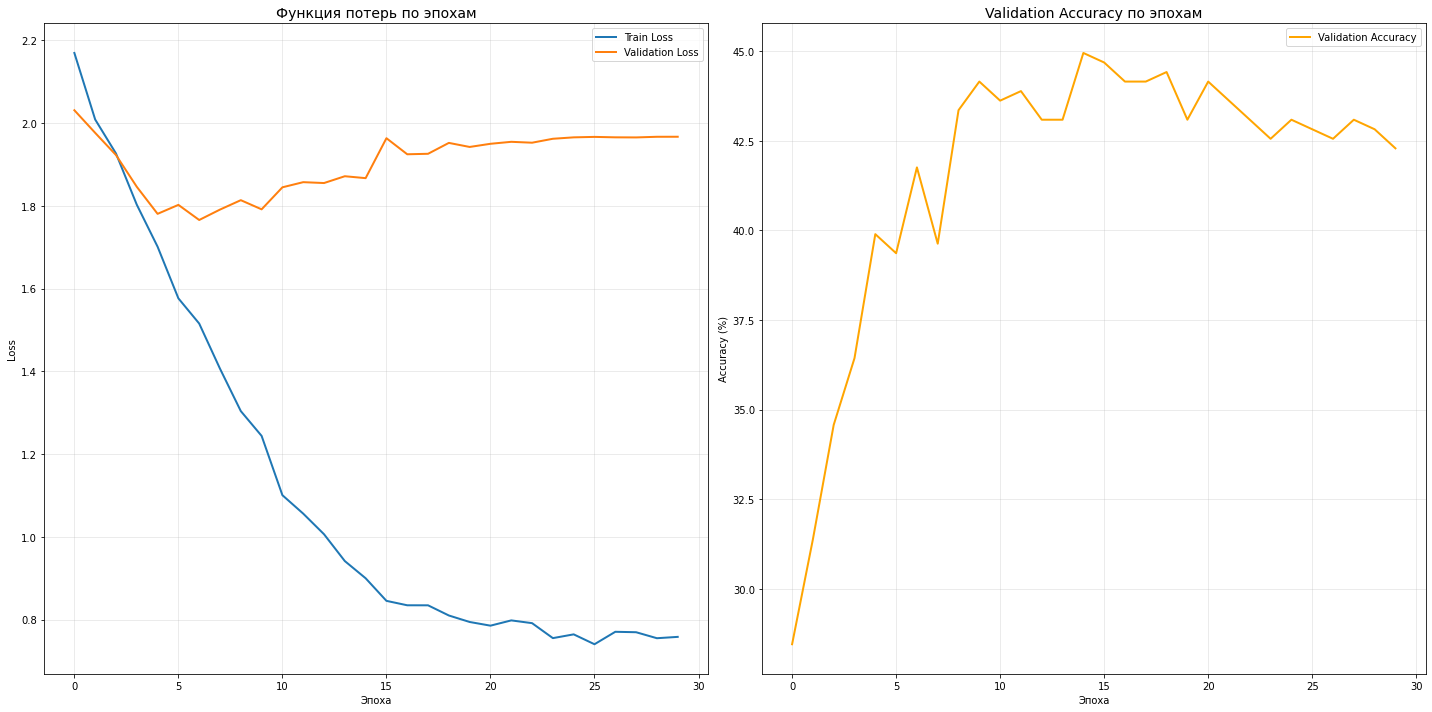

Classification Report
                     precision    recall  f1-score   support

          Accidents       0.50      0.17      0.25         6
            Culture       0.25      0.35      0.29        26
          Economics       0.62      0.70      0.66        86
             Health       0.00      0.00      0.00        15
           Politics       0.51      0.48      0.49        67
   Science and tech       0.31      0.30      0.31        50
            Society       0.05      0.04      0.04        25
              Sport       0.25      0.11      0.15         9
Travels and tourism       1.00      0.25      0.40         8
            Unknown       0.38      0.49      0.43        78
            Weather       0.00      0.00      0.00         6

           accuracy                           0.42       376
          macro avg       0.35      0.26      0.27       376
       weighted avg       0.41      0.42      0.41       376



In [124]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_title('Функция потерь по эпохам', fontsize=14)
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(val_acc, label='Validation Accuracy', linewidth=2, color='orange')
axes[1].set_title('Validation Accuracy по эпохам', fontsize=14)
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



all_predictions = []
all_labels = []

model.eval()
with torch.no_grad():
    for data, target in val_loader:
        data = data.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        
        all_predictions.extend(pred.cpu().numpy())
        all_labels.extend(target.numpy())

report = classification_report(all_labels, all_predictions, target_names=label_encoder.classes_, zero_division=0)
print("Classification Report")
print(report)

In [128]:
def predict_text(text, model, tokenizer, label_encoder, max_len=MAX_LEN):
    model.eval()
    text_processed = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([text_processed])[0]

    if len(sequence) < max_len:
        sequence = sequence + [0] * (max_len - len(sequence))
    else:
        sequence = sequence[:max_len]
    text_tensor = torch.tensor([sequence], dtype=torch.long).to(device)
    
    with torch.no_grad():
        output = model(text_tensor)
        probabilities = torch.softmax(output, dim=1)
        prediction = output.argmax(dim=1)
    
    top3_probs, top3_indices = torch.topk(probabilities, 3)
    predicted_class = label_encoder.classes_[prediction[0]]
    confidence = probabilities[0, prediction[0]].item()
    
    top3_predictions = []
    for i in range(3):
        class_idx = top3_indices[0, i].item()
        class_name = label_encoder.classes_[class_idx]
        prob = top3_probs[0, i].item()
        top3_predictions.append((class_name, prob))
    
    return predicted_class, confidence, top3_predictions

test_examples = [
    "Новые санкции США против России вступили в силу сегодня",
    "Футбольный матч закончился со счетом 2:1 в пользу домашней команды",
    "Внедрение цифровых технологий в транспортную систему сократит пробки на 30%",
    "Курс доллара достиг исторического максимума на бирже",
    "Пожар в жилом доме унес жизни трех человек"
]

print("Примеры предсказаний:")
for example in test_examples:
    predicted, confidence, top3 = predict_text(example, model, tokenizer, label_encoder)
    print(f"\n'{example[:60]}...'")
    print(f"  Предсказанная тема: {predicted} (confidence: {confidence:.3f})")
    print(f"  Топ-3 варианта:")
    for i, (topic, prob) in enumerate(top3):
        print(f"    {i+1}. {topic}: {prob:.3f}")

Примеры предсказаний:

'Новые санкции США против России вступили в силу сегодня...'
  Предсказанная тема: Politics (confidence: 0.985)
  Топ-3 варианта:
    1. Politics: 0.985
    2. Unknown: 0.014
    3. Culture: 0.000

'Футбольный матч закончился со счетом 2:1 в пользу домашней к...'
  Предсказанная тема: Unknown (confidence: 0.285)
  Топ-3 варианта:
    1. Unknown: 0.285
    2. Culture: 0.261
    3. Economics: 0.129

'Внедрение цифровых технологий в транспортную систему сократи...'
  Предсказанная тема: Unknown (confidence: 0.602)
  Топ-3 варианта:
    1. Unknown: 0.602
    2. Economics: 0.286
    3. Society: 0.042

'Курс доллара достиг исторического максимума на бирже...'
  Предсказанная тема: Economics (confidence: 0.689)
  Топ-3 варианта:
    1. Economics: 0.689
    2. Politics: 0.218
    3. Unknown: 0.042

'Пожар в жилом доме унес жизни трех человек...'
  Предсказанная тема: Unknown (confidence: 0.393)
  Топ-3 варианта:
    1. Unknown: 0.393
    2. Society: 0.325
    3. Culture: